<a href="https://colab.research.google.com/github/MatiasRivas00/Clasificacion_Celulas_Sanguineas/blob/main/Clasificacion_Celulas_Sanguineas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Células Sanguíneas

Nombres:

*   Valentina Aguilar Iturrieta
*   Matias Rivas Aguilera


En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [ ]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:00<00:00, 334MB/s]


'blood.zip'

In [ ]:
# Descomprimimos el dataset
!unzip blood.zip

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
from torchvision.io import read_image
from PIL import Image

# Definición del Entrenamiento

In [ ]:
''' Definición Entrenamiento '''

def train_model(model, criterio, optimizer, scheduler, num_epochs = 10):
  since = time.time()

  train_acc = []
  train_loss = []

  test_acc = []
  test_loss = []
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)
    
    #Train model
    scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterio(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
      
    print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #Testing 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterio(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    test_loss.append(epoch_loss)
    test_acc.append(epoch_acc)
      
    print('Testing Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best Testing accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, train_loss, test_loss

# Análisis Previo

Se graficarán distintas características de los datos de TRAIN, TEST y VAL, que ayudarán a entender con qué se está trabajando:

In [ ]:
BASE_PATH = "images/"
classes = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

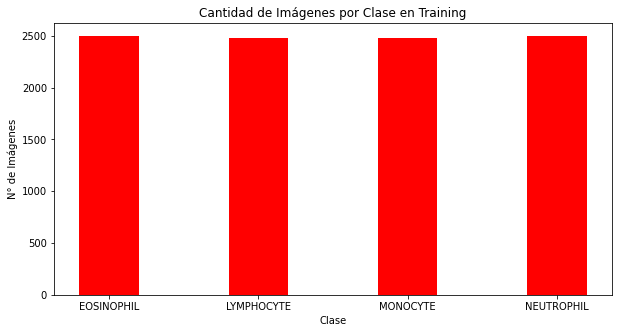

In [ ]:
''' TRAINING INFO '''

train_info = [len(os.listdir(f"{BASE_PATH}/TRAIN/{name_class}")) for name_class in classes]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, train_info, color ='red', width = 0.4)
 
plt.xlabel("Clase")
plt.ylabel("N° de Imágenes")
plt.title("Cantidad de Imágenes por Clase en Training")
plt.show()

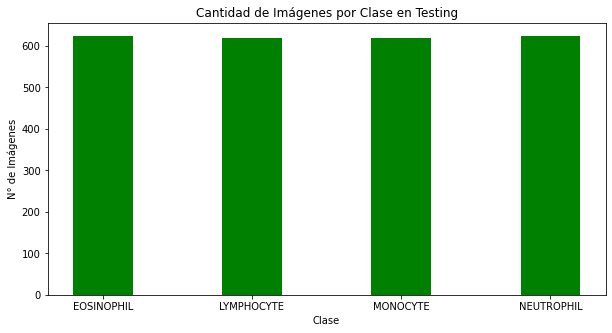

In [ ]:
''' TESTING INFO '''

testing_info = [len(os.listdir(f"{BASE_PATH}/TEST/{name_class}")) for name_class in classes]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, testing_info, color ='green', width = 0.4)
 
plt.xlabel("Clase")
plt.ylabel("N° de Imágenes")
plt.title("Cantidad de Imágenes por Clase en Testing")
plt.show()

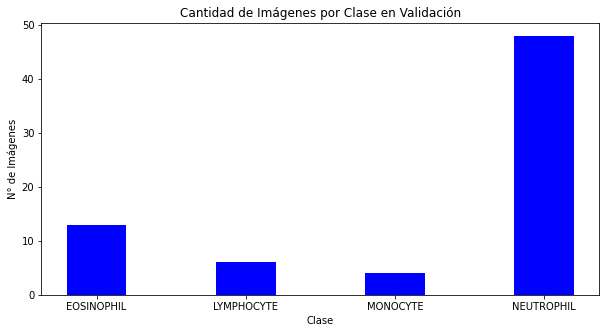

In [ ]:
''' VALIDATION INFO '''

val_info = [len(os.listdir(f"{BASE_PATH}/VAL/{name_class}")) for name_class in classes]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(classes, val_info, color ='blue', width = 0.4)
 
plt.xlabel("Clase")
plt.ylabel("N° de Imágenes")
plt.title("Cantidad de Imágenes por Clase en Validación")
plt.show()

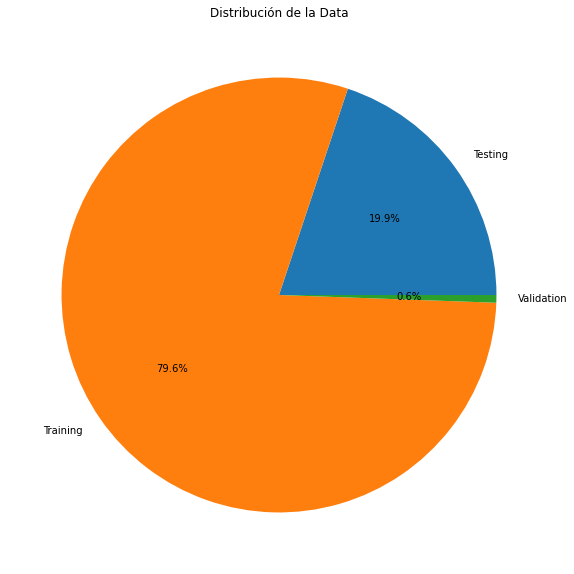

In [ ]:
def get_info(path):
  classes = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
  amount_of_data = 0
  for name_class in classes:
    listof_images = os.listdir(f"{path}/{name_class}")
    amount_of_data += len(listof_images)
  return amount_of_data

te = get_info("images/TEST")
tra = get_info("images/TRAIN")
val = get_info("images/VAL")

labels = 'Testing', 'Training', 'Validation'
sizes = [te, tra, val]
 
# Creating plot
fig = plt.figure(figsize =(10, 10))
plt.pie(sizes, labels = labels, autopct='%1.1f%%')

plt.title("Distribución de la Data")
 
# show plot
plt.show()

### Conclusiones del Análisis Previo

- La cantidad de data de testing en proporción a la de training parece ser correcta.
- La distribución de las clases tanto en testing como en training es homogénea, por lo que se cree que no debiera existir predominancia de alguna clase en la red neuronal.
- La cantidad de data de validación es muy escasa y no está homogéneamente distribuida. Por lo que si nos basamos en la data de validación directamente para sacar algunas conclusiones, puede que la red presente buenos resultados, pero estos no serán representativos, pues la mayoría de la data de validacion está concentrada en la clase NEUTROPHIL mientras que para la clase MONOCYTE hay apenas data.

# Organización de la Data

In [ ]:
class BloodDataset(torch.utils.data.Dataset):
  def __init__(self, root, split, transform):
    self.root = root
    self.split = split
    self.transform = transform
    self.class2idx = dict()

    self.class2idx['EOSINOPHIL'] = 0
    self.class2idx['LYMPHOCYTE'] = 1
    self.class2idx['MONOCYTE'] = 2
    self.class2idx['NEUTROPHIL'] = 3

    self.classes = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']
    self.images = []
    self.labels = []

    # Extracción de paths y clases para cada imagen
    for class_name in self.classes:
      rootof_images_names = os.path.join(self.root, f'{self.split}/{class_name}/')
      listof_images_names = os.listdir(rootof_images_names)
      for im in listof_images_names:
        self.images.append(im.strip())
        self.labels.append(class_name)
  
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    name_label = self.labels[idx]
    label = self.class2idx[name_label]

    image_path = os.path.join(self.root, self.split, name_label, self.images[idx])
    image = Image.open(image_path)
    im = image.convert('RGB')

    if self.transform:
      image = self.transform(im)
      
    return image, label

### Preparación de la Data

In [ ]:
''' Extracción de Data '''

train_dataset = BloodDataset(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

test_dataset = BloodDataset(root='images/', split='TEST',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

In [ ]:
''' DataLoaders '''

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

In [ ]:
''' Clases '''

class_names = train_dataset.classes

In [ ]:
''' Dispositivo '''

device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Entrenamientos

A continuación se presentarán 9 intentos de entrenamiento, para así analizar y concluir qué modelo escoger:

## Entrenamiento Primer Intento

### Fine Tuning

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training Loss: 1.2506 Acc: 0.4253
Testing Loss: 1.0155 Acc: 0.5661
Epoch 2/10
----------
Training Loss: 0.8465 Acc: 0.6635
Testing Loss: 0.7831 Acc: 0.6771
Epoch 3/10
----------
Training Loss: 0.6467 Acc: 0.7459
Testing Loss: 0.6946 Acc: 0.6944
Epoch 4/10
----------
Training Loss: 0.5392 Acc: 0.7842
Testing Loss: 0.6449 Acc: 0.7177
Epoch 5/10
----------
Training Loss: 0.4611 Acc: 0.8092
Testing Loss: 0.6512 Acc: 0.7201
Epoch 6/10
----------
Training Loss: 0.4285 Acc: 0.8221
Testing Loss: 0.6344 Acc: 0.7254
Epoch 7/10
----------
Training Loss: 0.4048 Acc: 0.8388
Testing Loss: 0.5873 Acc: 0.7398
Epoch 8/10
----------
Training Loss: 0.4005 Acc: 0.8359
Testing Loss: 0.6173 Acc: 0.7266
Epoch 9/10
----------
Training Loss: 0.3981 Acc: 0.8376
Testing Loss: 0.5798 Acc: 0.7419
Epoch 10/10
----------
Training Loss: 0.3957 Acc: 0.8401
Testing Loss: 0.5864 Acc: 0.7439
Training complete in 12m 12s
Best Testing accucary: 0.7439


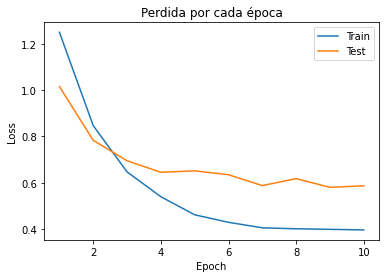

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### No Fine Tuning

In [ ]:
# Freeze

#Transfer Learning
model_conv = models.resnet18(pretrained=True)

# Freezing
for param in model_conv.parameters():
  param.requires_grad = False
  
num_ft = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ft,4)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

model_conv, train_loss, test_loss = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
Training Loss: 1.4011 Acc: 0.2896
Testing Loss: 1.3153 Acc: 0.3752
Epoch 2/10
----------
Training Loss: 1.2535 Acc: 0.4306
Testing Loss: 1.2273 Acc: 0.4391
Epoch 3/10
----------
Training Loss: 1.1695 Acc: 0.4993
Testing Loss: 1.1864 Acc: 0.4809
Epoch 4/10
----------
Training Loss: 1.1178 Acc: 0.5311
Testing Loss: 1.1487 Acc: 0.5099
Epoch 5/10
----------
Training Loss: 1.0851 Acc: 0.5562
Testing Loss: 1.1198 Acc: 0.5183
Epoch 6/10
----------
Training Loss: 1.0590 Acc: 0.5629
Testing Loss: 1.1091 Acc: 0.5300
Epoch 7/10
----------
Training Loss: 1.0392 Acc: 0.5784
Testing Loss: 1.1060 Acc: 0.5384
Epoch 8/10
----------
Training Loss: 1.0452 Acc: 0.5687
Testing Loss: 1.0990 Acc: 0.5287
Epoch 9/10
----------
Training Loss: 1.0368 Acc: 0.5749
Testing Loss: 1.1037 Acc: 0.5267
Epoch 10/10
----------
Training Loss: 1.0330 Acc: 0.5801
Testing Loss: 1.1165 Acc: 0.5292
Training complete in 8m 40s
Best Testing accucary: 0.5384


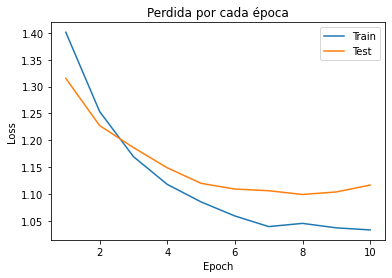

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch") 
plt.ylabel("Loss")  
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- Como se esperaba, el modelo sin ningún tipo de precaución contra el overfitting, presenta overtfitting. Esto se puede apreciar fácilmente en los gráficos de perdida a través de la épocas en donde la perdida mejora para la data de training, pero deja de presentar mejoras considerables en la data de testing.
- Hacer backpropagation en la capa convolucional produce mejores resultados que no hacerlo, así que esto se mantendrá para los siguientes intentos.

## Entrenamiento Segundo Intento: L2 Regularization

### Lambda 1e-3

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler)

Epoch 1/10
----------
Training Loss: 1.2785 Acc: 0.4005
Testing Loss: 1.0540 Acc: 0.5637
Epoch 2/10
----------
Training Loss: 0.8716 Acc: 0.6444
Testing Loss: 0.8226 Acc: 0.6707
Epoch 3/10
----------
Training Loss: 0.6392 Acc: 0.7496
Testing Loss: 0.6787 Acc: 0.7181
Epoch 4/10
----------
Training Loss: 0.5220 Acc: 0.7883
Testing Loss: 0.6408 Acc: 0.7254
Epoch 5/10
----------
Training Loss: 0.4531 Acc: 0.8195
Testing Loss: 0.6035 Acc: 0.7358
Epoch 6/10
----------
Training Loss: 0.4256 Acc: 0.8274
Testing Loss: 0.6163 Acc: 0.7402
Epoch 7/10
----------
Training Loss: 0.3941 Acc: 0.8431
Testing Loss: 0.6153 Acc: 0.7370
Epoch 8/10
----------
Training Loss: 0.3797 Acc: 0.8493
Testing Loss: 0.6216 Acc: 0.7342
Epoch 9/10
----------
Training Loss: 0.3799 Acc: 0.8504
Testing Loss: 0.5957 Acc: 0.7515
Epoch 10/10
----------
Training Loss: 0.3857 Acc: 0.8450
Testing Loss: 0.6013 Acc: 0.7431
Training complete in 12m 2s
Best Testing accucary: 0.7515


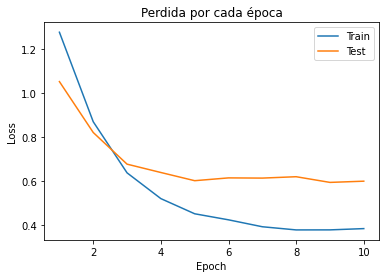

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Lambda 1e-4

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler)

Epoch 1/10
----------
Training Loss: 1.2960 Acc: 0.3937
Testing Loss: 1.1502 Acc: 0.4982
Epoch 2/10
----------
Training Loss: 0.8823 Acc: 0.6491
Testing Loss: 0.8310 Acc: 0.6478
Epoch 3/10
----------
Training Loss: 0.6666 Acc: 0.7331
Testing Loss: 0.7407 Acc: 0.6880
Epoch 4/10
----------
Training Loss: 0.5519 Acc: 0.7761
Testing Loss: 0.6453 Acc: 0.7089
Epoch 5/10
----------
Training Loss: 0.4651 Acc: 0.8159
Testing Loss: 0.6612 Acc: 0.7121
Epoch 6/10
----------
Training Loss: 0.4244 Acc: 0.8312
Testing Loss: 0.6192 Acc: 0.7314
Epoch 7/10
----------
Training Loss: 0.4009 Acc: 0.8387
Testing Loss: 0.5790 Acc: 0.7475
Epoch 8/10
----------
Training Loss: 0.3889 Acc: 0.8435
Testing Loss: 0.5917 Acc: 0.7334
Epoch 9/10
----------
Training Loss: 0.3925 Acc: 0.8437
Testing Loss: 0.5580 Acc: 0.7563
Epoch 10/10
----------
Training Loss: 0.3924 Acc: 0.8391
Testing Loss: 0.5888 Acc: 0.7334
Training complete in 11m 45s
Best Testing accucary: 0.7563


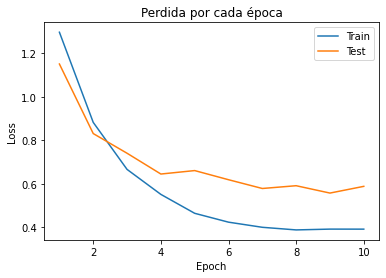

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Lambda 1e-5

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training Loss: 1.2906 Acc: 0.3890
Testing Loss: 1.1165 Acc: 0.5308
Epoch 2/10
----------
Training Loss: 0.8845 Acc: 0.6439
Testing Loss: 0.7960 Acc: 0.6771
Epoch 3/10
----------
Training Loss: 0.6453 Acc: 0.7415
Testing Loss: 0.6487 Acc: 0.7298
Epoch 4/10
----------
Training Loss: 0.5294 Acc: 0.7850
Testing Loss: 0.6367 Acc: 0.7298
Epoch 5/10
----------
Training Loss: 0.4623 Acc: 0.8160
Testing Loss: 0.6505 Acc: 0.7201
Epoch 6/10
----------
Training Loss: 0.4168 Acc: 0.8306
Testing Loss: 0.6039 Acc: 0.7435
Epoch 7/10
----------
Training Loss: 0.3977 Acc: 0.8368
Testing Loss: 0.5913 Acc: 0.7479
Epoch 8/10
----------
Training Loss: 0.3979 Acc: 0.8363
Testing Loss: 0.5845 Acc: 0.7427
Epoch 9/10
----------
Training Loss: 0.3820 Acc: 0.8476
Testing Loss: 0.6244 Acc: 0.7346
Epoch 10/10
----------
Training Loss: 0.3851 Acc: 0.8433
Testing Loss: 0.6149 Acc: 0.7282
Training complete in 12m 8s
Best Testing accucary: 0.7479


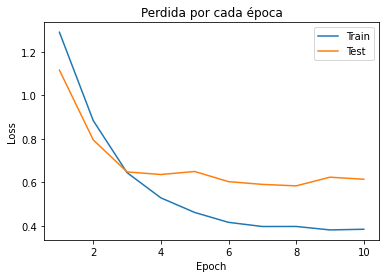

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- Por los resultados que se presentan en los gráficos pareciese que está bien encaminado utilizar *L2 Regularization*, pues la curva de perdida para la data de testing parece estar convergiendo a algo, por lo tanto se tratará de promover su uso en los intentos siguientes.
- Pareciese que utilizar **Lambda = 1e-5** no produce cambios notorios, sin embargo para **Lambda = 1e-4** y **Lambda = 1e-3** se producen resultados más destacables.

## Entrenamiento Tercer Intento: Usando ADAM

#### Learning rate 0.001

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------
Training Loss: 0.5748 Acc: 0.7496
Testing Loss: 1.4235 Acc: 0.6385
Epoch 2/10
----------
Training Loss: 0.2969 Acc: 0.8794
Testing Loss: 0.7118 Acc: 0.7197
Epoch 3/10
----------
Training Loss: 0.2460 Acc: 0.8995
Testing Loss: 1.0562 Acc: 0.6988
Epoch 4/10
----------
Training Loss: 0.2325 Acc: 0.9073
Testing Loss: 1.1990 Acc: 0.6389
Epoch 5/10
----------
Training Loss: 0.2208 Acc: 0.9104
Testing Loss: 1.7266 Acc: 0.6297
Epoch 6/10
----------
Training Loss: 0.1984 Acc: 0.9213
Testing Loss: 3.7448 Acc: 0.5468
Epoch 7/10
----------
Training Loss: 0.1595 Acc: 0.9393
Testing Loss: 1.0276 Acc: 0.7435
Epoch 8/10
----------
Training Loss: 0.1265 Acc: 0.9511
Testing Loss: 0.9937 Acc: 0.7334
Epoch 9/10
----------
Training Loss: 0.1114 Acc: 0.9566
Testing Loss: 0.9463 Acc: 0.7636
Epoch 10/10
----------
Training Loss: 0.1046 Acc: 0.9577
Testing Loss: 1.1332 Acc: 0.7266
Training complete in 12m 39s
Best Testing accucary: 0.7636


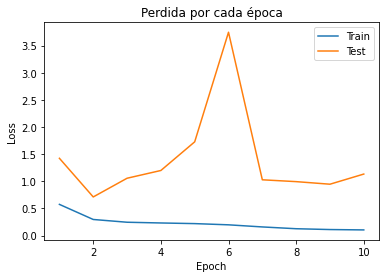

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

#### Learning rate 0.01

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.01)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------
Training Loss: 1.6711 Acc: 0.2489
Testing Loss: 1.3928 Acc: 0.2493
Epoch 2/10
----------
Training Loss: 1.4099 Acc: 0.2660
Testing Loss: 1.3895 Acc: 0.2384
Epoch 3/10
----------
Training Loss: 1.2635 Acc: 0.3819
Testing Loss: 9.4549 Acc: 0.2525
Epoch 4/10
----------
Training Loss: 1.0545 Acc: 0.5508
Testing Loss: 7.1856 Acc: 0.2614
Epoch 5/10
----------
Training Loss: 0.8222 Acc: 0.6615
Testing Loss: 1.5336 Acc: 0.5078
Epoch 6/10
----------
Training Loss: 0.6778 Acc: 0.7099
Testing Loss: 1.9365 Acc: 0.4009
Epoch 7/10
----------
Training Loss: 0.5411 Acc: 0.7599
Testing Loss: 0.6097 Acc: 0.7266
Epoch 8/10
----------
Training Loss: 0.4840 Acc: 0.7847
Testing Loss: 0.6382 Acc: 0.7141
Epoch 9/10
----------
Training Loss: 0.4704 Acc: 0.8001
Testing Loss: 0.6008 Acc: 0.7222
Epoch 10/10
----------
Training Loss: 0.4419 Acc: 0.8047
Testing Loss: 0.5818 Acc: 0.7374
Training complete in 11m 35s
Best Testing accucary: 0.7374


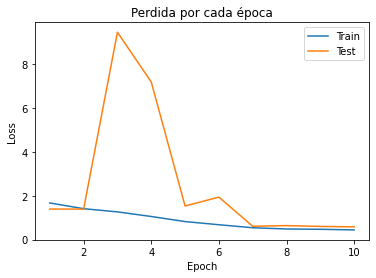

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### L2 Regularization

#### Learning rate 0.001

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#L2 Regularization
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------
Training Loss: 0.5476 Acc: 0.7636
Testing Loss: 1.1468 Acc: 0.6502
Epoch 2/10
----------
Training Loss: 0.2918 Acc: 0.8815
Testing Loss: 1.0446 Acc: 0.6409
Epoch 3/10
----------
Training Loss: 0.2433 Acc: 0.9006
Testing Loss: 1.3742 Acc: 0.6803
Epoch 4/10
----------
Training Loss: 0.2324 Acc: 0.9074
Testing Loss: 0.9083 Acc: 0.7218
Epoch 5/10
----------
Training Loss: 0.2141 Acc: 0.9120
Testing Loss: 1.2306 Acc: 0.6944
Epoch 6/10
----------
Training Loss: 0.1940 Acc: 0.9239
Testing Loss: 1.1041 Acc: 0.6618
Epoch 7/10
----------
Training Loss: 0.1500 Acc: 0.9391
Testing Loss: 1.1571 Acc: 0.7133
Epoch 8/10
----------
Training Loss: 0.1245 Acc: 0.9513
Testing Loss: 1.1163 Acc: 0.7214
Epoch 9/10
----------
Training Loss: 0.1137 Acc: 0.9553
Testing Loss: 1.0705 Acc: 0.7290
Epoch 10/10
----------
Training Loss: 0.1034 Acc: 0.9603
Testing Loss: 1.2887 Acc: 0.7125
Training complete in 11m 55s
Best Testing accucary: 0.7290


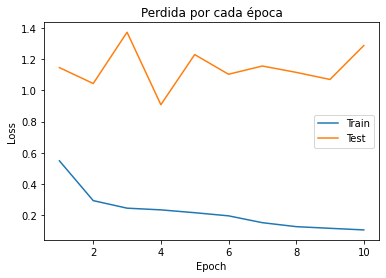

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

#### Learning rate 0.01

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#L2 Regularization
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.01, weight_decay=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------
Training Loss: 1.6034 Acc: 0.2615
Testing Loss: 2.5989 Acc: 0.2477
Epoch 2/10
----------
Training Loss: 1.3985 Acc: 0.2849
Testing Loss: 1.4152 Acc: 0.2493
Epoch 3/10
----------
Training Loss: 1.3802 Acc: 0.3051
Testing Loss: 1.3903 Acc: 0.2670
Epoch 4/10
----------
Training Loss: 1.2701 Acc: 0.4251
Testing Loss: 1.5574 Acc: 0.3040
Epoch 5/10
----------
Training Loss: 1.1364 Acc: 0.4889
Testing Loss: 4.3847 Acc: 0.2256
Epoch 6/10
----------
Training Loss: 0.8283 Acc: 0.6470
Testing Loss: 1.1053 Acc: 0.5103
Epoch 7/10
----------
Training Loss: 0.6474 Acc: 0.7151
Testing Loss: 0.7186 Acc: 0.6711
Epoch 8/10
----------
Training Loss: 0.5747 Acc: 0.7467
Testing Loss: 0.7336 Acc: 0.6663
Epoch 9/10
----------
Training Loss: 0.5347 Acc: 0.7692
Testing Loss: 0.6938 Acc: 0.6932
Epoch 10/10
----------
Training Loss: 0.5145 Acc: 0.7689
Testing Loss: 0.7964 Acc: 0.6594
Training complete in 11m 51s
Best Testing accucary: 0.6932


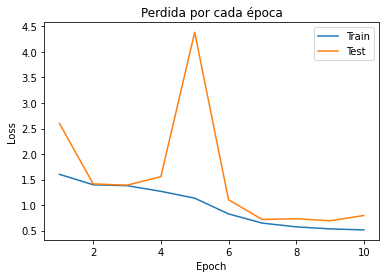

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- Tal parece que intentar acelerar la convergencia empeora la situación del overfitting, sin embargo se obtuvieron resultados mejores para testing también.
- Como Adam hace converger más rápido hacia un mínimo local, se tratará de usar learning rates más altos en el siguiente intento para ver si la aleatoriedad de los saltos (es decir, cómo se actualizan los parámetros) llega en algún momento a un buen mínimo local, pues este modelo en algún momento por mera aleatoriedad tuvo un accuracy de poco más de 76%, es decir más alto de los que se venían viendo. Por lo que se intentará usar Adam pero evitando el overfitting en la medida de lo posible.

## Entrenamiento Cuarto Intento: Usando Distintos Learning rates

### Learning rate 0.1

#### SDG

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

Epoch 1/20
----------
Training Loss: 3.5810 Acc: 0.2511
Testing Loss: 2.5319 Acc: 0.2509
Epoch 2/20
----------
Training Loss: 1.9958 Acc: 0.2502
Testing Loss: 1.6585 Acc: 0.2437
Epoch 3/20
----------
Training Loss: 1.8433 Acc: 0.2497
Testing Loss: 1.5877 Acc: 0.2493
Epoch 4/20
----------
Training Loss: 1.5189 Acc: 0.2485
Testing Loss: 1.3938 Acc: 0.2513
Epoch 5/20
----------
Training Loss: 1.3919 Acc: 0.2508
Testing Loss: 1.3892 Acc: 0.2417
Epoch 6/20
----------
Training Loss: 1.3903 Acc: 0.2515
Testing Loss: 1.3935 Acc: 0.2517
Epoch 7/20
----------
Training Loss: 1.3885 Acc: 0.2483
Testing Loss: 1.3867 Acc: 0.2517
Epoch 8/20
----------
Training Loss: 1.3868 Acc: 0.2494
Testing Loss: 1.3870 Acc: 0.2557
Epoch 9/20
----------
Training Loss: 1.3866 Acc: 0.2486
Testing Loss: 1.3865 Acc: 0.2469
Epoch 10/20
----------
Training Loss: 1.3867 Acc: 0.2462
Testing Loss: 1.3859 Acc: 0.2525
Epoch 11/20
----------
Training Loss: 1.3868 Acc: 0.2443
Testing Loss: 1.3864 Acc: 0.2545
Epoch 12/20
-------

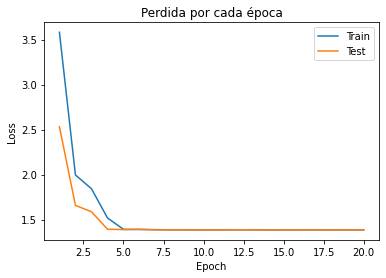

In [ ]:
# loss / epoch
plt.plot(range(1, 21), train_loss, label='Train')
plt.plot(range(1, 21), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

#### Adam

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------
Training Loss: 3.6509 Acc: 0.2467
Testing Loss: 3.0738 Acc: 0.2453
Epoch 2/10
----------
Training Loss: 1.4146 Acc: 0.2389
Testing Loss: 1.3950 Acc: 0.2469
Epoch 3/10
----------
Training Loss: 1.4011 Acc: 0.2417
Testing Loss: 1.3930 Acc: 0.2529
Epoch 4/10
----------
Training Loss: 1.3974 Acc: 0.2471
Testing Loss: 1.3977 Acc: 0.2541
Epoch 5/10
----------
Training Loss: 1.3905 Acc: 0.2492
Testing Loss: 1.3911 Acc: 0.2493
Epoch 6/10
----------
Training Loss: 1.3882 Acc: 0.2440
Testing Loss: 1.3872 Acc: 0.2501
Epoch 7/10
----------
Training Loss: 1.3869 Acc: 0.2509
Testing Loss: 1.3862 Acc: 0.2501
Epoch 8/10
----------
Training Loss: 1.3864 Acc: 0.2464
Testing Loss: 1.3864 Acc: 0.2493
Epoch 9/10
----------
Training Loss: 1.3865 Acc: 0.2460
Testing Loss: 1.3864 Acc: 0.2437
Epoch 10/10
----------
Training Loss: 1.3864 Acc: 0.2483
Testing Loss: 1.3863 Acc: 0.2521
Training complete in 11m 20s
Best Testing accucary: 0.2541


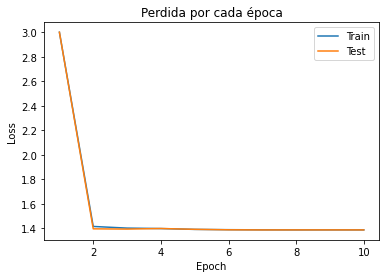

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 11), tr_loss, label='Train')
plt.plot(range(1, 11), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Learning rate 0.5

#### SDG

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

# Dropout 25%
model_ft.dropout = nn.Dropout(0.25)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.5, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

Epoch 1/20
----------
Training Loss: 8.9255 Acc: 0.2658
Testing Loss: 16.6428 Acc: 0.2380
Epoch 2/20
----------
Training Loss: 1.3827 Acc: 0.3251
Testing Loss: 1.3768 Acc: 0.3185
Epoch 3/20
----------
Training Loss: 1.3168 Acc: 0.3624
Testing Loss: 1.3582 Acc: 0.2907
Epoch 4/20
----------
Training Loss: 1.2655 Acc: 0.4143
Testing Loss: 1.2726 Acc: 0.3836
Epoch 5/20
----------
Training Loss: 1.2318 Acc: 0.4405
Testing Loss: 1.3115 Acc: 0.3663
Epoch 6/20
----------
Training Loss: 1.1973 Acc: 0.4605
Testing Loss: 1.2423 Acc: 0.4302
Epoch 7/20
----------
Training Loss: 1.1739 Acc: 0.4792
Testing Loss: 1.2491 Acc: 0.4125
Epoch 8/20
----------
Training Loss: 1.1602 Acc: 0.4871
Testing Loss: 1.2580 Acc: 0.4178
Epoch 9/20
----------
Training Loss: 1.1506 Acc: 0.4865
Testing Loss: 1.2616 Acc: 0.4138
Epoch 10/20
----------
Training Loss: 1.1533 Acc: 0.4859
Testing Loss: 1.2373 Acc: 0.4125
Epoch 11/20
----------
Training Loss: 1.1357 Acc: 0.4954
Testing Loss: 1.2345 Acc: 0.4266
Epoch 12/20
------

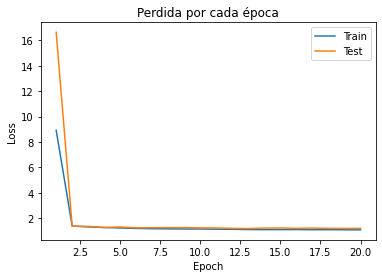

In [ ]:
# loss / epoch
plt.plot(range(1, 21), train_loss, label='Train')
plt.plot(range(1, 21), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

#### Adam

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.5)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------
Training Loss: 14.2647 Acc: 0.2539
Testing Loss: 5.0067 Acc: 0.2461
Epoch 2/10
----------
Training Loss: 1.4483 Acc: 0.2474
Testing Loss: 1.4209 Acc: 0.2477
Epoch 3/10
----------
Training Loss: 1.3919 Acc: 0.2487
Testing Loss: 1.3879 Acc: 0.2529
Epoch 4/10
----------
Training Loss: 1.3910 Acc: 0.2498
Testing Loss: 1.3909 Acc: 0.2557
Epoch 5/10
----------
Training Loss: 1.3901 Acc: 0.2483
Testing Loss: 1.3877 Acc: 0.2493
Epoch 6/10
----------
Training Loss: 1.3912 Acc: 0.2465
Testing Loss: 1.3966 Acc: 0.2485
Epoch 7/10
----------
Training Loss: 1.3894 Acc: 0.2435
Testing Loss: 1.3873 Acc: 0.2457
Epoch 8/10
----------
Training Loss: 1.3867 Acc: 0.2485
Testing Loss: 1.3867 Acc: 0.2473
Epoch 9/10
----------
Training Loss: 1.3868 Acc: 0.2433
Testing Loss: 1.3865 Acc: 0.2505
Epoch 10/10
----------
Training Loss: 1.3865 Acc: 0.2526
Testing Loss: 1.3872 Acc: 0.2465
Training complete in 11m 16s
Best Testing accucary: 0.2557


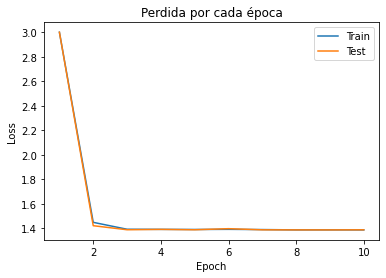

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 11), tr_loss, label='Train')
plt.plot(range(1, 11), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- Cabe destacar que esta sección existe más por la curiosidad de ver qué sucede más que con la esperanza de que sea un buen método para obtener mejores resultados.
- Pese al punto anterior se obtuvieron resultados bastante prometedores, pues, pese a que no hay mayor porcentaje de accuracy, sí hay un mayor equilibrio entre la data de training y la data de testing, además de que hay leves mejoras en cada iteración, por lo que en un futuro intento se harán más interaciones para analizar los resultados.
- Como último intento antes de probar con los mejores resultados, se utilizará una red distinta.
- Pareciese que la capa convolucional hace bien su trabajo, pues la data de training en algunos casos podía clasificarlos demasiado bien, el gran problema es el overfitting. Sin embargo con estos resultados puede que haya esperanza con un learning rate más alto.

## Entrenamiento Quinto Intento: Usando una Red distinta

In [ ]:
import torch
# Transfer Learning
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4, bias=True)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.5, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 10)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training Loss: 2.9471 Acc: 0.2520
Testing Loss: 2.3758 Acc: 0.2457
Epoch 2/10
----------
Training Loss: 1.4200 Acc: 0.2534
Testing Loss: 1.4092 Acc: 0.2489
Epoch 3/10
----------
Training Loss: 1.4015 Acc: 0.2508
Testing Loss: 1.4674 Acc: 0.2489
Epoch 4/10
----------
Training Loss: 1.3951 Acc: 0.2547
Testing Loss: 1.4986 Acc: 0.2525
Epoch 5/10
----------
Training Loss: 1.3961 Acc: 0.2511
Testing Loss: 1.4308 Acc: 0.2513
Epoch 6/10
----------
Training Loss: 1.3948 Acc: 0.2491
Testing Loss: 1.4005 Acc: 0.2505
Epoch 7/10
----------
Training Loss: 1.3884 Acc: 0.2537
Testing Loss: 1.3948 Acc: 0.2493
Epoch 8/10
----------
Training Loss: 1.3873 Acc: 0.2448
Testing Loss: 1.3923 Acc: 0.2493
Epoch 9/10
----------
Training Loss: 1.3877 Acc: 0.2452
Testing Loss: 1.3874 Acc: 0.2501
Epoch 10/10
----------
Training Loss: 1.3882 Acc: 0.2437
Testing Loss: 1.3870 Acc: 0.2505
Training complete in 13m 24s
Best Testing accucary: 0.2525


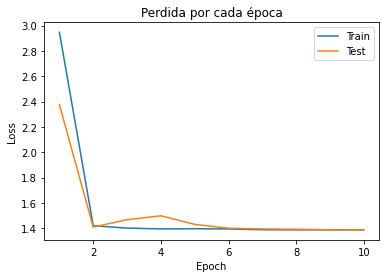

In [ ]:
# loss / epoch
plt.plot(range(1, 11), train_loss, label='Train')
plt.plot(range(1, 11), test_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- GoogLeNet no parece tener el potencial necesario para poder aprender de la data.
- VGG no se pudo utilizar por falta de memoria.

## Entrenamiento Sexto Intento Intento: Más Épocas

### Learning rate 0.001

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training Loss: 0.6048 Acc: 0.7392
Testing Loss: 1.2291 Acc: 0.6643
Epoch 2/20
----------
Training Loss: 0.3269 Acc: 0.8640
Testing Loss: 0.6618 Acc: 0.7624
Epoch 3/20
----------
Training Loss: 0.2733 Acc: 0.8870
Testing Loss: 2.0857 Acc: 0.5722
Epoch 4/20
----------
Training Loss: 0.2377 Acc: 0.9065
Testing Loss: 0.7658 Acc: 0.7499
Epoch 5/20
----------
Training Loss: 0.2092 Acc: 0.9139
Testing Loss: 2.1650 Acc: 0.6289
Epoch 6/20
----------
Training Loss: 0.1975 Acc: 0.9189
Testing Loss: 1.1065 Acc: 0.6647
Epoch 7/20
----------
Training Loss: 0.1546 Acc: 0.9387
Testing Loss: 0.7163 Acc: 0.7575
Epoch 8/20
----------
Training Loss: 0.1247 Acc: 0.9480
Testing Loss: 0.7733 Acc: 0.7591
Epoch 9/20
----------
Training Loss: 0.1154 Acc: 0.9547
Testing Loss: 0.8645 Acc: 0.7443
Epoch 10/20
----------
Training Loss: 0.1095 Acc: 0.9577
Testing Loss: 0.8112 Acc: 0.7559
Epoch 11/20
----------
Training Loss: 0.1034 Acc: 0.9600
Testing Loss: 0.8724 Acc: 0.7523
Epoch 12/20
----------
Training Loss: 0.0

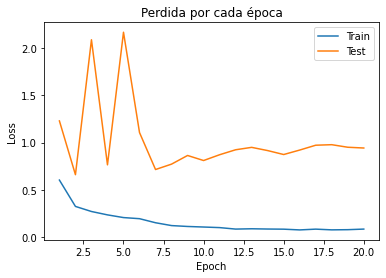

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 21), tr_loss, label='Train')
plt.plot(range(1, 21), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

###Learning rate 0.1

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

Epoch 1/20
----------
Training Loss: 3.4528 Acc: 0.2633
Testing Loss: 110.3927 Acc: 0.2702
Epoch 2/20
----------
Training Loss: 1.4141 Acc: 0.3051
Testing Loss: 1.5181 Acc: 0.3936
Epoch 3/20
----------
Training Loss: 1.1689 Acc: 0.4696
Testing Loss: 5.6020 Acc: 0.2155
Epoch 4/20
----------
Training Loss: 0.9116 Acc: 0.5665
Testing Loss: 8.3708 Acc: 0.2224
Epoch 5/20
----------
Training Loss: 0.8708 Acc: 0.5923
Testing Loss: 3.3311 Acc: 0.2268
Epoch 6/20
----------
Training Loss: 0.7429 Acc: 0.6631
Testing Loss: 1.0750 Acc: 0.5674
Epoch 7/20
----------
Training Loss: 0.6577 Acc: 0.7098
Testing Loss: 0.6292 Acc: 0.7302
Epoch 8/20
----------
Training Loss: 0.5988 Acc: 0.7324
Testing Loss: 0.7656 Acc: 0.6892
Epoch 9/20
----------
Training Loss: 0.5653 Acc: 0.7458
Testing Loss: 0.6952 Acc: 0.6972
Epoch 10/20
----------
Training Loss: 0.5495 Acc: 0.7478
Testing Loss: 0.7127 Acc: 0.6783
Epoch 11/20
----------
Training Loss: 0.5118 Acc: 0.7750
Testing Loss: 0.6218 Acc: 0.7193
Epoch 12/20
-----

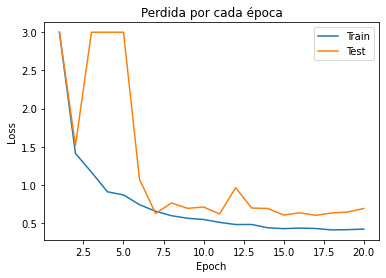

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 21), tr_loss, label='Train')
plt.plot(range(1, 21), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Learning rate 0.5

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.5)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

Epoch 1/20
----------
Training Loss: 13.2634 Acc: 0.2469
Testing Loss: 43.9113 Acc: 0.2409
Epoch 2/20
----------
Training Loss: 1.4249 Acc: 0.2470
Testing Loss: 1.4266 Acc: 0.2529
Epoch 3/20
----------
Training Loss: 1.3951 Acc: 0.2476
Testing Loss: 1.3921 Acc: 0.2501
Epoch 4/20
----------
Training Loss: 1.3947 Acc: 0.2449
Testing Loss: 1.3919 Acc: 0.2465
Epoch 5/20
----------
Training Loss: 1.3903 Acc: 0.2507
Testing Loss: 1.3917 Acc: 0.2513
Epoch 6/20
----------
Training Loss: 1.3925 Acc: 0.2457
Testing Loss: 1.3922 Acc: 0.2505
Epoch 7/20
----------
Training Loss: 1.3882 Acc: 0.2501
Testing Loss: 1.3870 Acc: 0.2501
Epoch 8/20
----------
Training Loss: 1.3870 Acc: 0.2495
Testing Loss: 1.3870 Acc: 0.2481
Epoch 9/20
----------
Training Loss: 1.3878 Acc: 0.2479
Testing Loss: 1.3873 Acc: 0.2461
Epoch 10/20
----------
Training Loss: 1.3879 Acc: 0.2515
Testing Loss: 1.3867 Acc: 0.2521
Epoch 11/20
----------
Training Loss: 1.3870 Acc: 0.2498
Testing Loss: 1.3869 Acc: 0.2481
Epoch 12/20
-----

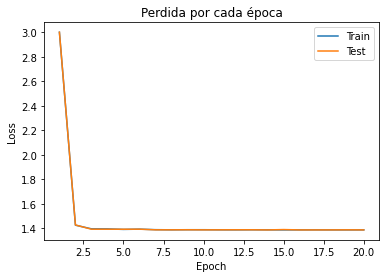

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 21), tr_loss, label='Train')
plt.plot(range(1, 21), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- En general las curvas que parecen presentar más overfitting son los que tienen el learning rate más bajo, lo que tiene bastante sentido pues el modelo no tiene oportunidad de generar resultados más variados, por lo que siempre termina apuntando al camino que lo lleva al mejor resultado para la data de training.
- En cambio, para learning rates más altos el modelo pareciese ir "peor" pero tiene unos resultados geniales graficamente, pues no hay overfitting, y el modelo mejora sus respuestas tanto para la data de training como para la de testing, lo que probablemente se debe a que aumenta la variabilidad del modelo, llevando al modelo a actualizar sus parámetros de forma tal que no se adapta 100% bien a la data de training, lo que da la posibilidad a mejorar en la data de testing.

## Entrenamiento Séptimo Intento: ¿Y si hacemos el crop en el centro?

### Motivación

#### Random Crop

In [ ]:
''' Extracción de Data con Random Crop'''

train_dataset_old = BloodDataset(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

test_dataset_old = BloodDataset(root='images/', split='TEST',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

In [ ]:
''' DataLoaders con Random Crop'''

train_loader_old = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader_old = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

#### Center Crop

In [ ]:
''' Extracción de Data con Center Crop'''

train_dataset = BloodDataset(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

test_dataset = BloodDataset(root='images/', split='TEST',
                                                transform=transforms.Compose([
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

In [ ]:
''' DataLoaders de Data con Center Crop '''

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)

#### Comparación

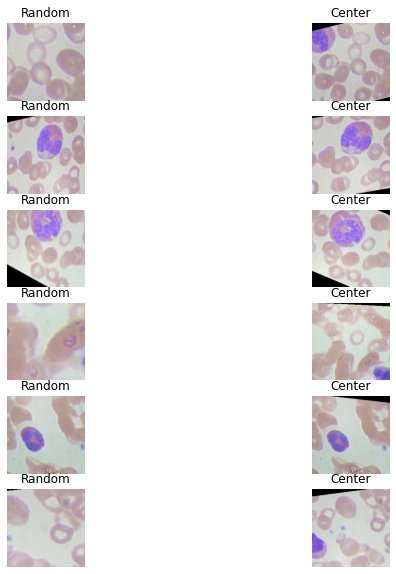

In [ ]:
fig = plt.figure(figsize=(10, 10))
rows = 6
cols = 2
names = ["Random", "Center"]
pos = 1
for i in range(rows):
  out = []
  loaders = [train_dataset_old, train_dataset]
  for j in range(cols):
    img = loaders[j][i][0]
    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig.add_subplot(rows, cols, pos)
    plt.imshow(inp)
    plt.axis('off')
    plt.title(names[j])
    pos += 1
    
plt.show()

Tal parece que del centro de la imagen y sin un cambio de escala se puede obtener mayor información, por lo cual se espera que la red neuronal pueda aprender mejor, y obtener mejores resultados en la data de testing. Lo cual tendría sentido pues pareciese que algunas imágenes de la izquierda (la que usa el random resized crop) obtiene en la mitad de los casos imágenes bastante ambiguas y poco descriptibles que incluso a una persona probablemente le costaría distinguir.

### El Modelo con Mejor Resultado en Testing

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

Epoch 1/20
----------
Training Loss: 0.2003 Acc: 0.9218
Testing Loss: 0.5132 Acc: 0.8428
Epoch 2/20
----------
Training Loss: 0.0153 Acc: 0.9961
Testing Loss: 0.8660 Acc: 0.8343
Epoch 3/20
----------
Training Loss: 0.0059 Acc: 0.9987
Testing Loss: 0.8304 Acc: 0.9031
Epoch 4/20
----------
Training Loss: 0.0052 Acc: 0.9985
Testing Loss: 1.0929 Acc: 0.8327
Epoch 5/20
----------
Training Loss: 0.0037 Acc: 0.9990
Testing Loss: 0.7840 Acc: 0.8947
Epoch 6/20
----------
Training Loss: 0.0053 Acc: 0.9986
Testing Loss: 1.2381 Acc: 0.7262
Epoch 7/20
----------
Training Loss: 0.0027 Acc: 0.9994
Testing Loss: 1.0189 Acc: 0.8733
Epoch 8/20
----------
Training Loss: 0.0005 Acc: 1.0000
Testing Loss: 0.9843 Acc: 0.8713
Epoch 9/20
----------
Training Loss: 0.0003 Acc: 1.0000
Testing Loss: 0.9832 Acc: 0.8717
Epoch 10/20
----------
Training Loss: 0.0003 Acc: 1.0000
Testing Loss: 0.9562 Acc: 0.8721
Epoch 11/20
----------
Training Loss: 0.0002 Acc: 1.0000
Testing Loss: 0.9647 Acc: 0.8725
Epoch 12/20
-------

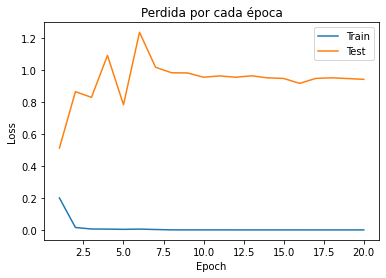

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 21), tr_loss, label='Train')
plt.plot(range(1, 21), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### La Curva más Prometedora

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

Epoch 1/20
----------
Training Loss: 4.3804 Acc: 0.3331
Testing Loss: 27.0891 Acc: 0.2642
Epoch 2/20
----------
Training Loss: 0.9147 Acc: 0.5940
Testing Loss: 1.9341 Acc: 0.5340
Epoch 3/20
----------
Training Loss: 0.5436 Acc: 0.7715
Testing Loss: 4.0627 Acc: 0.2923
Epoch 4/20
----------
Training Loss: 0.3988 Acc: 0.8363
Testing Loss: 3.6341 Acc: 0.5070
Epoch 5/20
----------
Training Loss: 0.2814 Acc: 0.8893
Testing Loss: 0.9777 Acc: 0.7849
Epoch 6/20
----------
Training Loss: 0.2305 Acc: 0.9064
Testing Loss: 0.4223 Acc: 0.8227
Epoch 7/20
----------
Training Loss: 0.1673 Acc: 0.9371
Testing Loss: 0.3985 Acc: 0.8581
Epoch 8/20
----------
Training Loss: 0.1291 Acc: 0.9501
Testing Loss: 0.3223 Acc: 0.8613
Epoch 9/20
----------
Training Loss: 0.1132 Acc: 0.9553
Testing Loss: 0.3256 Acc: 0.8593
Epoch 10/20
----------
Training Loss: 0.1001 Acc: 0.9621
Testing Loss: 0.3926 Acc: 0.8705
Epoch 11/20
----------
Training Loss: 0.0900 Acc: 0.9648
Testing Loss: 0.3478 Acc: 0.8725
Epoch 12/20
------

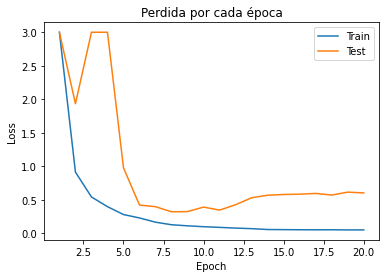

In [ ]:
# loss / epoch
t_loss = [min(i, 3) for i in test_loss]
tr_loss = [min(i, 3) for i in train_loss]
plt.plot(range(1, 21), tr_loss, label='Train')
plt.plot(range(1, 21), t_loss, label='Test')
plt.xlabel("Epoch")  
plt.ylabel("Loss") 
plt.title("Perdida por cada época")  
plt.legend()
plt.show()

### Conclusiones

- Al parecer la teoría de la motivación se cumplió, pues la red logró obtener mucho mejores resultados que los anteriormente vistos.
- Como se pudo apreciar, el modelo que obtuvo el mejor resultado de testing presentaba demasiado overfitting, esto empeoró con el center crop.
- Por otro lado, la curva más prometedora, logró obtener resultados bastante positivos, en los que el modelo casi lograba 100% de accuracy en data de training, pero no lo hacía (resultado positivo pues daba pie a que la red siguiera mejorando en la data de testing), mientras tanto la data de testing obtenía los mejores resultados vistos hasta ahora.

# Conclusión

### Modelo Escogido

In [ ]:
torch.manual_seed(1234)

In [ ]:
''' Extracción de Data con Center Crop'''

train_dataset = BloodDataset(root='images/', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

test_dataset = BloodDataset(root='images/', split='TEST',
                                                transform=transforms.Compose([
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

val_dataset = BloodDataset(root='images/', split='VAL',
                                                transform=transforms.Compose([
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))

In [ ]:
''' DataLoaders de Data con Center Crop '''

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

In [ ]:
# Transfer Learning
model_ft = models.resnet18(pretrained=True)

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft, train_loss, test_loss = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, 20)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training Loss: 3.3292 Acc: 0.3252
Testing Loss: 6.9986 Acc: 0.3981
Epoch 2/20
----------
Training Loss: 0.9700 Acc: 0.5268
Testing Loss: 1.1267 Acc: 0.5533
Epoch 3/20
----------
Training Loss: 0.5848 Acc: 0.7515
Testing Loss: 2.3103 Acc: 0.4451
Epoch 4/20
----------
Training Loss: 0.4409 Acc: 0.8151
Testing Loss: 0.9665 Acc: 0.7772
Epoch 5/20
----------
Training Loss: 0.3246 Acc: 0.8676
Testing Loss: 1.9884 Acc: 0.5722
Epoch 6/20
----------
Training Loss: 0.2654 Acc: 0.8899
Testing Loss: 2.4916 Acc: 0.7390
Epoch 7/20
----------
Training Loss: 0.1945 Acc: 0.9271
Testing Loss: 0.5217 Acc: 0.8030
Epoch 8/20
----------
Training Loss: 0.1650 Acc: 0.9394
Testing Loss: 0.5064 Acc: 0.8122
Epoch 9/20
----------
Training Loss: 0.1513 Acc: 0.9423
Testing Loss: 0.4873 Acc: 0.8267
Epoch 10/20
----------
Training Loss: 0.1451 Acc: 0.9452
Testing Loss: 0.4886 Acc: 0.8295
Epoch 11/20
----------
Training Loss: 0.1340 Acc: 0.9498
Testing Loss: 0.5799 Acc: 0.8319
Epoch 12/20
----------
Training Loss: 0.1

In [ ]:
#Testing 
model_ft.eval()
running_loss = 0.0
running_corrects = 0.0

for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
    
  with torch.set_grad_enabled(False):
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    loss = nn.CrossEntropyLoss()(outputs, labels)
      
  running_loss += loss.item() * inputs.size(0)
  running_corrects += torch.sum(preds == labels.data)
  
loss = running_loss /len(test_dataset)
acc = running_corrects.double() / len(test_dataset)
  
print('Testing Loss: {:.4f} Acc: {:.4f}'.format(loss, acc))

Testing Loss: 0.6986 Acc: 0.8412


In [ ]:
#Evaluation 
model_ft.eval()
running_loss = 0.0
running_corrects = 0.0

for inputs, labels in val_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
    
  with torch.set_grad_enabled(False):
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    loss = nn.CrossEntropyLoss()(outputs, labels)
      
  running_loss += loss.item() * inputs.size(0)
  running_corrects += torch.sum(preds == labels.data)
  
loss = running_loss /len(val_dataset)
acc = running_corrects.double() / len(val_dataset)
  
print('Validation Loss: {:.4f} Acc: {:.4f}'.format(loss, acc))

Validation Loss: 0.4905 Acc: 0.8028


### Conclusiones
- Primero nos gustaría aclarar que tratamos de utilizar técnicas de data augmentation, pero no tuvimos éxito porque no entendíamos del todo bien como utilizarlas y no teníamos demasiado tiempo para investigar su funcionamiento.
- Sumado al punto anterior, creemos que el data augmentation hubiese traido resultados positivos al modelo escogido, pues así bajaría su accuracy y daría pie a que el modelo mejore en la data de testing.
- Nos gustaría recalcar que el modelo escogido fue ese no por tener el porcentaje más alto de accuracy, sino porque era el que presentaba un gráfico más prometedor que todos los demás.
- Adam mezclado con un learning rate alto produjo grandes resultados, creo que este fue el resultado más inesperado del caso de estudio, pues como se mencionaba en la sección, probar un learning rate más alto era por curiosidad más que por obtener resultados, sin embargo aparecieron resultados bastante buenos y con mucha información útil.
- El modelo actual no está libre de overfitting, sin embargo creemos que es el que más logró reducir el problema y obtener los resultados más positivos.
- El mayor problema de esta tarea era la falta de data para poder entrenar la red apropiadamente, sin embargo fue interesante tratar de encontrar maneras en que el modelo dejara de memorizar.
- Otra conclusión importante y que fue clave para poder salir del limbo del 75% fue hacer un crop en el centro de la imagen, probablemente la imagen es bastante homogénea en algunas partes, por lo tanto hacer crop de forma aleatoria terminaba por entorpecer el aprendizaje, dado que podía darse la casualidad de que el RandomResizedCrop extrayera una parte inútil de la imagen que incluso a un humano lo costaría discernir su clase.
- Cabe destacar que la data de validación al ser muy escasa y encima no homogénea, no va a producir resultados muy representativos, sin embargo nos puede dar una leve idea de cómo funciona la red, y en este caso parece funcionar bastante bien.
- Como reflexión final creemos que es una red que aún puede mejorar mucho más, pero de la que no se podría tener certeza hasta poder tener una data de validación más representativa y homogénea.